In [1]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch.distributions as td
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from sklearn.cluster import KMeans, DBSCAN

In [319]:
data_dir = "C:/Users/Phili/Documents/exjobb/data/"
data = pd.read_csv(data_dir + "nusat2.csv")
data = data.dropna()
print(len(data))
idx = np.random.choice(np.arange(len(data)), 5000, replace=False)
data = data.iloc[idx]
#data[data.iloc[:, :21].abs() > 0.3] = np.nan 
data = data.dropna()
print(len(data))

14401
5000


In [320]:
t_df = data[["t"]]
y_df = data[["y"]]
sec_df = data[["sector"]]
X = data.iloc[:, :120]
# X[X.abs() > 0.5] = np.nan
# X = X.dropna()

In [321]:
data.shape

(5000, 123)

In [322]:
X = (1.0 + X.T).cumprod().T.values
#X = X.values

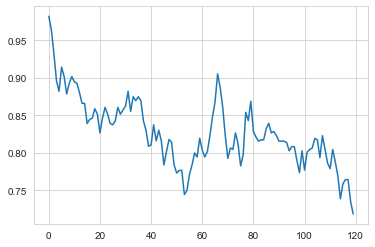

In [323]:
_ = plt.plot(X[123])

In [324]:
labels, levels = pd.factorize(sec_df.iloc[:,0])
sec_df.loc[:,"labels"] = labels

C:\Users\Phili\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Phili\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [325]:
secs = sec_df.sector.unique()
sec_dict = {i: secs[i] for i in range(len(secs))}

In [326]:
t = t_df.values
y = y_df.values
sec = sec_df.labels.values

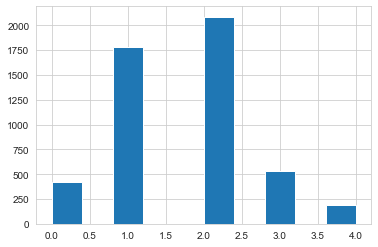

In [327]:
_ = plt.hist(y)

In [328]:
X_train, X_test, y_train, y_test, s_train, s_test, t_train, t_test = train_test_split(X, y, sec, t, test_size=0.2)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

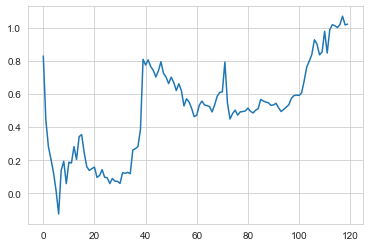

In [329]:
_ = plt.plot(X_train[124])

In [330]:
class Data(Dataset):
    def __init__(self, X, y, sec, t):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
        self.sec = torch.from_numpy(sec[:, None])
        self.t = torch.from_numpy(t)
        
        self.loader = DataLoader(self, shuffle=True, batch_size = 32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.X[idx].float(), self.y[idx].float(), self.sec[idx].float(), self.t[idx].float()

In [331]:
class Latent(nn.Module):
    def __init__(self, i, o):
        super().__init__()
        self.mu = nn.Linear(i, o)
        self.log_var = nn.Linear(i, o)
        
        self.elu = nn.ELU()
        
    def _rep(self, mu, log_var):
        eps = torch.randn_like(log_var)
        sigma = torch.exp(0.5 * log_var)
        return mu + eps*sigma
    
    def forward(self, x):
        mu = self.mu(x)
        #mu = self.elu(mu)
        log_var = self.log_var(x)
        #log_var = self.elu(log_var)
        z = self._rep(mu, log_var)
        return z, mu, log_var

class Dense(nn.Module):
    def __init__(self, i,o):
        super().__init__()
        self.l = nn.Sequential(
            nn.Linear(i, o),
            nn.BatchNorm1d(o),
            nn.ELU()
        )
    def forward(self, x):
        return self.l(x)
    
class Normal(nn.Module):
    def __init__(self, i, o):
        super().__init__()
        self.mu = nn.Linear(i, o)
        self.log_var = nn.Linear(i,o)
    
        #self.ht = nn.Hardtanh(min_val = -6, max_val = 10)
    
    def forward(self, x):
        mu = self.mu(x)
        log_var = self.log_var(x)
        #log_var = self.ht(log_var)
        sigma = torch.exp(0.5 * log_var) + 1e-4
        return td.Normal(mu, sigma)
    
class ST(nn.Module):
    def __init__(self, i, o):
        super().__init__()
        self.df = nn.Linear(i, o)
    
    def forward(self, x):
        df = self.df(x)
        df = torch.exp(0.5 * df) + 2
        return td.StudentT(df)

In [357]:
class CVAE(nn.Module):
    def __init__(self, T, n_y, n_s, n_z):
        super().__init__()
        
        self.enc = nn.Sequential(
            Dense(T + n_y + n_s, 256),
            Dense(256, 128),
            Dense(128, 64),
            Dense(64, 16),
            Latent(16, n_z)
        )
        
       
        self.dec = nn.Sequential(
            Dense(n_z + n_y + n_s, 16),
            Dense(16, 64),
            Dense(64, 128),
            Dense(128, 256),
            Normal(256, T)
        )
        
#         self.enc = nn.Sequential(
#             Dense(T + n_y + n_s, 64),
#             Dense(64, 64),
#             Dense(64, 16),
#             Latent(16, n_z)
#         )
#         self.dec = nn.Sequential(
#             Dense(n_z + n_y + n_s, 16),
#             Dense(16, 64),
#             Dense(64, 64),
#             Normal(64, T)
#         )
        self.prior = nn.Sequential(
            Dense(n_y + n_s, 16),
            Latent(16, n_z)
        )
        
        
        self.mse = nn.MSELoss(reduction="sum")
    
    def _dkl_loss(self, prior_mean, prior_log_var, z_mean, z_log_var):
        z_var = z_log_var.exp()
        prior_var = prior_log_var.exp()
        kld = torch.sum(prior_log_var - z_log_var + ((z_var + (z_mean - prior_mean).pow(2)) / (prior_var*2)) - 0.5)
        return kld
    
    def _rcl_loss(self, dist, x):
        return -dist.log_prob(x).sum()
    
    def encode(self, x,y, s):
        y = make_one_hot(y, C = 5)
        s = make_one_hot(s, C= 11)
        x = torch.cat([x,y, s], 1)
        return self.enc(x)

    def decode(self, z, y, s):
        y = make_one_hot(y, C = 5)
        s = make_one_hot(s, C = 11)
        z = torch.cat([z,y, s], 1)
        return self.dec(z)
    
    def prio(self, y, s):
        y = make_one_hot(y, C = 5)
        s = make_one_hot(s, C = 11)
        return self.prior(torch.cat([y,s], 1))
    
    def forward(self, x, y,s, beta = 1.0):
        z, mu, log_var = self.encode(x,y,s)
        #prior, prior_mu, prior_log_var = self.prio(y,s)
        #dkl = self._dkl_loss(prior_mu, prior_log_var, mu, log_var)
        dkl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        dist = self.decode(z,y, s)
        rcl = self._rcl_loss(dist, x)
        #rcl = self.mse(dist, x)
        return dist, rcl + dkl*beta#, rcl, dkl*beta
    
    def sample(self, y, s):
        y = make_one_hot(y, C = 5)
        s = make_one_hot(s, C = 11)
        z, _, _ = self.prior(torch.cat([y,s], 1))
        dist = self.decode(z, y, s)
        return dist

In [358]:
train_data = Data(X_train, y_train, s_train, t_train)
test_data = Data(X_test, y_test, s_test, t_test)

In [359]:
def make_one_hot(labels, C = 5):
    y = torch.eye(C) 
    return y[labels.long()].squeeze(1)
class Trainer:
    def __init__(self, vae, train_data, test_data, cuda=False):
        self.train_data = train_data
        self.test_data = test_data
        
        if cuda:
            self.vae = vae.cuda()
            self.device = torch.device("cuda")
        else:
            self.vae = vae
            self.device = torch.device("cpu")
        
        
        self.opt = optim.Adam(vae.parameters(), lr=1e-3)
        self.sched = optim.lr_scheduler.ReduceLROnPlateau(self.opt, patience=30, verbose = True)
        #self.sched =  optim.lr_scheduler.StepLR(self.opt, 50, 0.1)


    
    def _train(self, e, burn_in = 0):
        self.vae.train()
        tot_loss = 0
        beta = 0
        if e > burn_in:
            beta = 1
        for i, (x,y,s, t) in enumerate(self.train_data.loader):
            #y = make_one_hot(y, C=5)
            #s = make_one_hot(s, C=11)
            x = Variable(x).to(self.device)
            self.opt.zero_grad()
            gen_x, loss = self.vae(x, y, s, beta)
            loss.backward()
            self.opt.step()
            tot_loss += loss.item()
        return tot_loss
    
    def _test(self, e, burn_in = 0):
        self.vae.eval()
        with torch.no_grad():
            tot_loss = 0
            beta = 0
            if e > burn_in:
                beta = 1
            for i, (x,y,s, t) in enumerate(self.test_data.loader):
                #y = make_one_hot(y, C=5)
                #s = make_one_hot(s, C=11)
                x = Variable(x).to(self.device)
                gen_x, loss = self.vae(x,y,s, beta)
                tot_loss += loss.item()
            return tot_loss
    
    def fit(self, epochs, burn_in = 0, print_every = 10):
        losses = []
        for e in range(epochs):
            train_loss = self._train(e, burn_in)
            train_loss /= len(self.train_data)
            test_loss = self._test(e, burn_in)
            test_loss /= len(self.test_data)
            self.sched.step(test_loss)
            if e % print_every == 0:
                print(f"Epoch: {e}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss: .2f}")
            losses.append(pd.DataFrame({"Test":test_loss, "Train":train_loss}, index=[e]))
        return pd.concat(losses)

In [360]:
vae = CVAE(120, 5, 11, 16)

In [361]:
t = Trainer(vae, train_data, test_data)

In [362]:
len(train_data)

4000

In [363]:
losses = t.fit(200)

Epoch: 0, Train Loss: 112.86, Test Loss:  68.58
Epoch: 10, Train Loss: 58.17, Test Loss:  33.08
Epoch: 20, Train Loss: 47.86, Test Loss:  41.78
Epoch: 30, Train Loss: 40.76, Test Loss:  18.01
Epoch: 40, Train Loss: 37.59, Test Loss:  18.93
Epoch: 50, Train Loss: 37.38, Test Loss:  23.88
Epoch: 60, Train Loss: 36.81, Test Loss:  7.13
Epoch: 70, Train Loss: 34.33, Test Loss:  28.82
Epoch: 80, Train Loss: 28.00, Test Loss:  9.27
Epoch: 90, Train Loss: 26.57, Test Loss:  12.98
Epoch: 100, Train Loss: 30.64, Test Loss:  13.02
Epoch: 110, Train Loss: 31.08, Test Loss:  10.86
Epoch: 120, Train Loss: 26.83, Test Loss:  6.21
Epoch: 130, Train Loss: 31.46, Test Loss:  18.07


KeyboardInterrupt: 

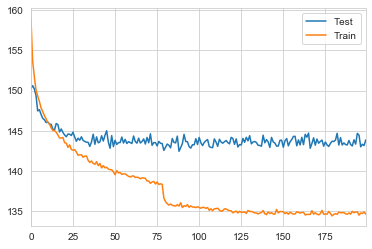

In [218]:
losses[losses < 1000].plot()

In [364]:
idx = np.random.choice(np.arange(len(train_data)), 500, replace=False)
X,y, s, t = train_data[:]
z, mu, log_var = vae.encode(X,y,s)
zz = pd.DataFrame(mu.detach().numpy(), columns = ["x", "y"])
zz["t"] = y.detach().numpy()
fig, ax = plt.subplots()
for name, grp in zz.groupby("t"):
    ax.plot(grp.x, grp.y, marker='o', linestyle='', ms=3, label=name, alpha=1)
ax.legend()
plt.show()

ValueError: Shape of passed values is (4000, 16), indices imply (4000, 2)

In [365]:
z.mean(dim=0), z.std(dim=0)

(tensor([ 0.0135,  0.0032,  0.0025,  0.0048,  0.0195,  0.0010, -0.0005,  0.0265,
          0.0074,  0.0398, -0.0052,  0.0017, -0.0024, -0.0083, -0.0019,  0.0191],
        grad_fn=<MeanBackward1>),
 tensor([0.9863, 1.0179, 1.1351, 0.9862, 0.9843, 0.9740, 0.9898, 0.9614, 0.9887,
         1.0001, 1.0222, 0.9666, 1.0132, 1.0055, 1.0414, 1.0060],
        grad_fn=<StdBackward1>))

In [366]:
vae.eval()

CVAE(
  (enc): Sequential(
    (0): Dense(
      (l): Sequential(
        (0): Linear(in_features=136, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
    )
    (1): Dense(
      (l): Sequential(
        (0): Linear(in_features=256, out_features=128, bias=True)
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
    )
    (2): Dense(
      (l): Sequential(
        (0): Linear(in_features=128, out_features=64, bias=True)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
    )
    (3): Dense(
      (l): Sequential(
        (0): Linear(in_features=64, out_features=16, bias=True)
        (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
    )
    (4): Laten

tensor([[2.]])


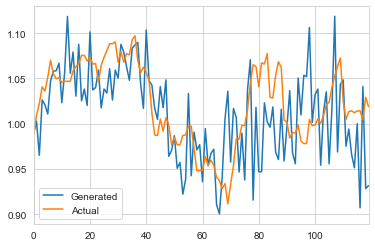

In [387]:
i = np.random.randint(0, len(train_data))
x, y, s, t = train_data[i:(i+1)]
print(y)
#y = torch.Tensor([0]).unsqueeze(0)
z, mu, log_var = vae.encode(x, y, s)
gen_x = vae.decode(z, y, s)
gen_x = pd.DataFrame(scaler.inverse_transform(gen_x.sample().detach().numpy()[0]), columns = ["Generated"])
x = pd.DataFrame(scaler.inverse_transform(x.detach().numpy()[0]), columns = ["Actual"])
x = gen_x.join(x)
x.plot()

In [370]:
def grad(x, dist):
    mu = dist.mean
    sigma = dist.scale
    grad = (x - mu) / (sigma.pow(2) + 1e-4)
    return grad

def gradm(x, dist):
    return x - dist

def sgd(x,y, s, vae, N=200, alpha=1, eps = 1):
    z_list = []
    x_list = []
    x_list.append(x.unsqueeze(0))
    z, mu, log_var = vae.encode(x,y,s)
    z_list.append(mu.unsqueeze(1))
    for i in range(N):
        #eps = eps / np.sqrt(i+1)
        x_z = x + np.sqrt(eps / np.sqrt(i+1)) * torch.randn_like(x)
        #print(x_z.shape, "x")
        z, mu, log_var = vae.encode(x_z,y,s)
        dist = vae.decode(z,y,s)
        z_list.append(mu.unsqueeze(1))
        g = grad(x_z, dist)
        #g /= g.norm()
        #print(g.shape, "G")
        x = x - alpha * g / np.sqrt(i+1)
        x_list.append(x.unsqueeze(0))
    return torch.cat(z_list, 1), torch.cat(x_list)

def adam(x,y, s, vae, N, alpha):
    z_list = []
    x_list = []
    beta_1 = 0.9
    beta_2 = 0.999
    eps = 1e-8
    m = 0
    v = 0
    
    z, mu, log_var = vae.encode(x,y,s)
    z_list.append(mu.unsqueeze(1))
    x_list.append(x.unsqueeze(0))
    
    
    for i in range(N):
        z, mu, log_var = vae.encode(x,y,s)
        gen_x = vae.decode(z,y,s)
        g = grad(x, gen_x)
        m = beta_1*m + (1-beta_1)*g
        v = beta_2*v + (1-beta_2)*g.pow(2)
        m_hat = m/(1-beta_1**(i+1))
        v_hat = v/(1-beta_2**(i+1))
        x = x - alpha*m_hat/(torch.sqrt(v_hat)+eps)
        z_list.append(mu.unsqueeze(1))
        x_list.append(x.unsqueeze(0))
    return torch.cat(z_list, 1), torch.cat(x_list)

In [353]:
x,y,s,t = train_data[2:3]
z_list, x_list = sgd(x,y,s,vae, 2000, 0.01, 0.1)

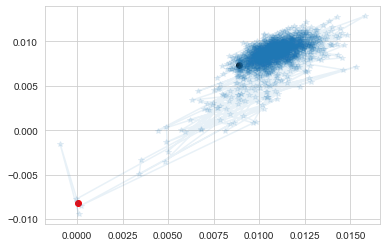

In [354]:
zz = z_list.detach().numpy()
_ = plt.plot(zz[0,:,0], zz[0,:,1],"*-" ,alpha=0.1)
_ = plt.scatter(zz[0,0,0], zz[0,0,1], c="r")
_ = plt.scatter(zz[0,-1,0], zz[0,-1,1], c="black")

In [303]:
zz[0]

array([[-1.9055489 , -1.6380087 ],
       [-1.8164402 , -1.6574148 ],
       [-1.9581369 , -1.6622864 ],
       ...,
       [-0.8749736 , -0.5728444 ],
       [-0.8870376 , -0.56445503],
       [-0.86868024, -0.5691123 ]], dtype=float32)

In [371]:
print(len(train_data))
with torch.no_grad():
    idx = np.random.choice(np.arange(len(train_data)), 1600, replace=False)
    X,y,s, t = train_data[idx]
    zz, xx = sgd(X,y,s, vae, 2000, 0.01, 1.0)
    

4000


In [307]:

zz_df = pd.DataFrame(zz[:,-1].detach().numpy(), columns = ["x", "y"])
zz_df["class"] = y.detach().numpy()
zz_first_df = pd.DataFrame(zz[:,0].detach().numpy(), columns = ["x", "y"])
zz_first_df["class"] = y.detach().numpy()

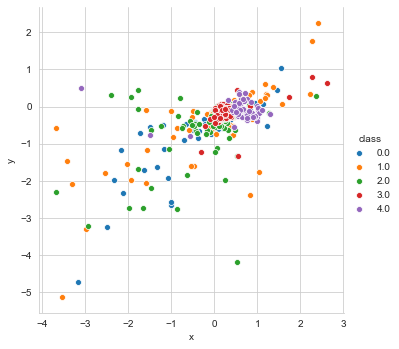

In [308]:
sns.pairplot(x_vars = "x", y_vars = "y", hue="class", data=zz_df, height=5)

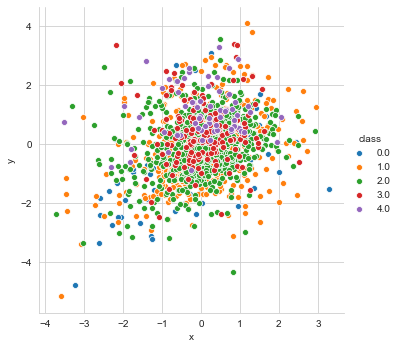

In [309]:
sns.pairplot(x_vars = "x", y_vars = "y", hue="class", data=zz_first_df, height=5)


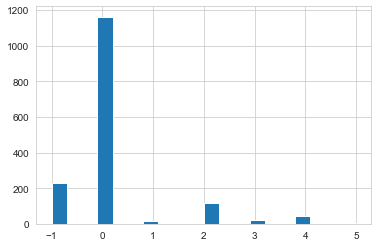

In [377]:
x = xx.detach().numpy()
last = x[-1]
last = last[~np.isnan(last).any(axis=1)]
x_df = pd.DataFrame(scaler.inverse_transform(x[0]))
kk = DBSCAN().fit_predict(x[-1])
x_df["cluster"] = kk
#zz_df["cluster"] = kk
a_df = pd.DataFrame(kk, columns = ["cluster"])

_ = plt.hist(kk, bins=20)


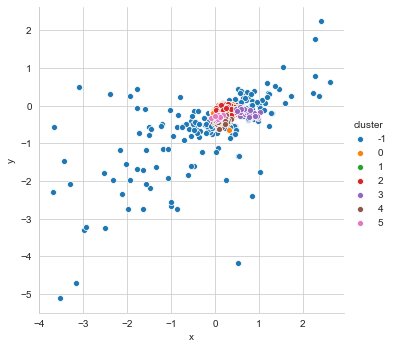

In [313]:
sns.pairplot(x_vars = "x", y_vars = "y", hue="cluster", data=zz_df, height=5)

In [314]:
a_df["y"] = y.detach().numpy()
a_df["s"] = s.detach().numpy()
a_df[a_df.cluster == 3].s.unique()

array([8., 1., 0., 6., 5., 4., 2.])

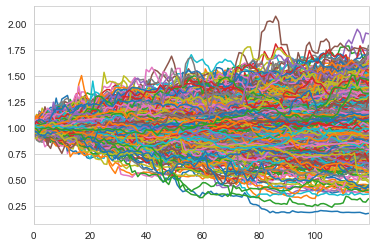

In [378]:
x_df[x_df.cluster == 0].drop("cluster", axis=1).T.plot(legend=False)


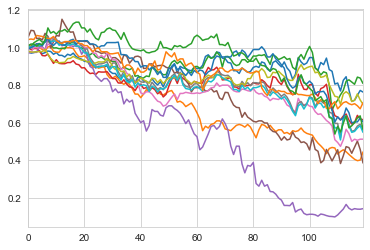

In [379]:
x_df[x_df.cluster == 1].drop("cluster", axis=1).T.plot(legend=False)


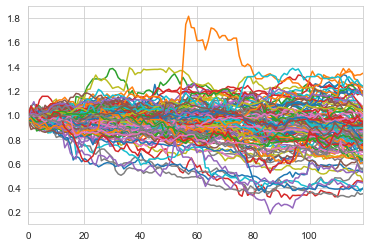

In [380]:
x_df[x_df.cluster == 2].drop("cluster", axis=1).T.plot(legend=False)


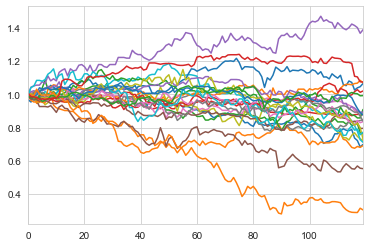

In [381]:
x_df[x_df.cluster == 3].drop("cluster", axis=1).T.plot(legend=False)


In [261]:
t_df = pd.DataFrame(t.detach().numpy(), columns = ["t"])
t_df["cluster"] = kk
t_df

,t,cluster
0,14.0,0
1,42.0,1
2,7.0,0
3,35.0,1
4,33.0,2
...,...,...
1595,29.0,1
1596,38.0,1
1597,39.0,1
1598,35.0,1


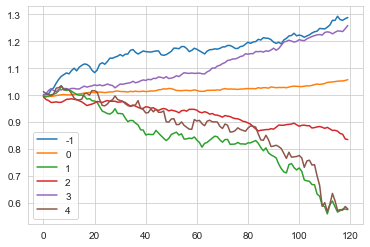

In [245]:
fig, ax = plt.subplots()
for name, grp in x_df.groupby("cluster"):
    ax.plot(grp.drop("cluster", axis=1).T.mean(axis=1), label=name)
ax.legend()
plt.show()

In [246]:
sec_dict

{0: 'Capital Goods',
 1: 'Energy',
 2: 'Technology',
 3: 'Consumer Cyclical',
 4: 'Financial',
 5: 'Consumer/Non-Cyclical',
 6: 'Basic Materials',
 7: 'Services',
 8: 'Healthcare',
 9: 'Transportation',
 10: 'Utilities'}

In [ ]:
s = torch.Tensor([0]).unsqueeze(0)
y = torch.Tensor([4]).unsqueeze(0)


sam = []
for _ in range(1000):
    z = torch.randn(2).unsqueeze(0)
    dist = vae.decode(z,y,s)
    sample = dist.sample().detach().numpy()
    sam.append(scaler.inverse_transform(sample))
sam = np.array(sam)
_ = plt.plot(sam.mean(axis=0)[0])

In [237]:
d =data.sort_index().iloc[-20:]
t_df = d[["t"]]
y_df = d[["y"]]
sec_df = d[["sector"]]
X = d.iloc[:, :120].values
# X[X.abs() > 0.5] = np.nan
# X = X.dropna()
labels, levels = pd.factorize(sec_df.iloc[:,0])
sec_df.loc[:,"labels"] = labels
t = t_df.values
y = y_df.values
sec = sec_df.labels.values
val_data = Data(X, y, sec, t)

C:\Users\Phili\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Phili\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [238]:
X, y, s, t = val_data[:]


In [239]:
sam = []
y = torch.Tensor([4]).expand_as(s)

z, mu, log_var = vae.encode(X,y,s)
dist = vae.decode(z,y,s)
sample = scaler.inverse_transform(dist.sample((1000,)).detach().numpy()).mean(axis=1)
sample.shape

(1000, 120)

In [240]:
ss = pd.DataFrame(sample.T)

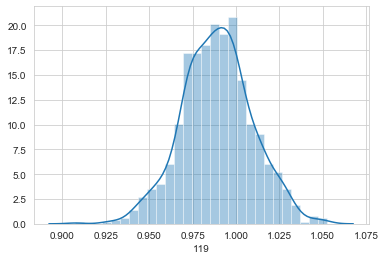

In [241]:

last = ss.iloc[-1]
_ = sns.distplot(last)

In [242]:
last.quantile(0.05)

0.9548016130924224

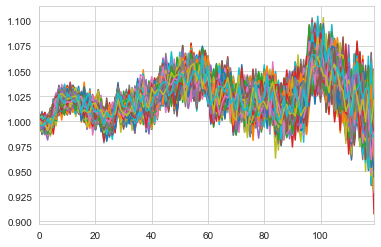

In [243]:
ss.plot(legend=False)
plt.savefig("pics/var_2.png")

In [104]:
y

tensor([[2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.]])